In [1]:
# Group number 1
# Assignment 8: Tracking and forecasting in conditions of measurement gaps
# Team members: Stepan Perminov, Polina Ponomareva, Kirill Shcherbakov, Daniil Svirskiy

# Library importing
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
class Ass9_1(object):
    def __init__(self):
        # Parameters
        self.N = 26 #points
        self.T = 2 #interval between measurements
        self.Vc0 = np.array([-50, -45])
        self.Xc0 = np.ones(2)*3500/np.sqrt(2)
        self.sigma_etD2 = 20**2
        self.sigma_etb2 = 0.02**2
#         self.sigma_etD2 = 50**2
#         self.sigma_etb2 = 0.0015**2
        
        # Trajectories
        self.Xc = self.true_c_trajectory(self.N, self.T, self.Xc0, self.Vc0)
        self.Xp = self.true_p_trajectory(self.N, self.Xc)
        self.Zp = self.measurements(self.N, self.Xp, self.sigma_etD2, self.sigma_etb2)
   
    def true_c_trajectory(self, n, T, Xc0, Vc0):
        Xc = np.zeros((2,n))
        Xc[:, 0] = Xc0
        for i in range(1,n):
            Xc[:, i] = Xc[:, i-1] + Vc0*T
        return Xc
    
    def true_p_trajectory(self, n, Xc):
        Xp = np.zeros((2,n))
        Xp[0,:] = np.sqrt(Xc[0,:]**2 + Xc[1,:]**2) #D
        Xp[1,:] = np.arctan(Xc[0,:]/Xc[1,:]) #bet
        return Xp

    def measurements(self, n, Xp, sigma_etD2, sigma_etb2):
        Zp = np.zeros((2,n))
        Zp[0,:] = Xp[0,:] + np.random.normal(0, np.sqrt(sigma_etD2), n) #D
        Zp[1,:] = Xp[1,:] + np.random.normal(0, np.sqrt(sigma_etb2), n) #bet
        return Zp
    
class Ass9_2(object):
    def __init__(self, Zp_fixed):
        # Parameters
        self.N = 26 #points
        self.T = 2 #interval between measurements

        self.sigma_etD2 = 20**2
        self.sigma_etb2 = 0.02**2
#         self.sigma_etD2 = 50**2
#         self.sigma_etb2 = 0.0015**2
        
        # Trajectories
        self.Zc = self.pseudo_measurements(self.N, Zp_fixed)
        
        # Initial conditions for Kalman filter algorithm
        self.X0 = np.array([40000, -20, 40000, -20])
        self.P0 = np.eye(4)*(10**10)
        self.F = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        self.H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
        
        # Covariance matrix of measurement error R
        self.R = self.matrix_R(self.N, Zp_fixed, self.sigma_etD2, self.sigma_etb2)
        
        self.Kalman = self.Kalman_filtration(self.N, self.H, self.P0, self.X0, self.F, self.R, self.Zc)
         
    def pseudo_measurements(self, n, Zp):
        Zc = np.zeros((2,n))
        Zc[0,:] = Zp[0,:]*np.sin(Zp[1,:]) #x
        Zc[1,:] = Zp[0,:]*np.cos(Zp[1,:]) #y
        return Zc
    
    def matrix_R(self, n, Zp, sd2, sb2):
        R = np.zeros((2,2,n))
        D = Zp[0,:]
        bet = Zp[1,:]
        
        R[0,0,:] = (np.sin(bet)**2)*sd2 + ((D*np.cos(bet))**2)*sb2
        R[0,1,:] = np.sin(bet)*np.cos(bet)*(sd2 - (D**2)*sb2)
        R[1,0,:] = R[0,1,:]
        R[1,1,:] = (np.cos(bet)**2)*sd2 + ((D*np.sin(bet))**2)*sb2
        
        return R
    
    def Kalman_filtration(self, n, H, P0, X0, F, R, Zc):
        # Initialization of matrixes
        P_1 = np.zeros((4,4,n))
        X_1 = np.zeros((4,n))
        P_ = np.zeros((4,4,n))
        X_ = np.zeros((4,n))
        HT = H.T
        K = np.zeros((4,2,n))

        # Initial P for filtering
        P_[:,:,0] = P0

        # Initial X_filt for filtering
        X_[:,0] = X0

        # Kalman filtering
        for i in range(1,n):
            P_1[:,:,i] = (F.dot(P_[:,:,i-1])).dot(F.T)

            X_1[:,i] = F.dot(X_[:,i-1].reshape(4,1)).reshape(4)
            K[:,:,i] = ((P_1[:,:,i].dot(HT)).dot(inv((H.dot(P_1[:,:,i])).dot(HT) + R[:,:,i]))) #4 на 2

            X_[:,i] = (X_1[:,i].reshape(4,1) + K[:,:,i].dot(Zc[:,i].reshape(2,1) - H.dot(X_1[:,i].reshape(4,1)))).reshape(4)
            P_[:,:,i] = P_1[:,:,i] - (K[:,:,i].dot(H)).dot(P_1[:,:,i])

        K = np.delete(K, 0, axis = 2)
        
        X_est = np.zeros((4,n))
        X_est[0,:] = np.sqrt(X_1[0,:]**2 + X_1[2,:]**2)
        X_est[1,:] = np.arctan(X_1[0,:]/X_1[2,:])
        X_est[2,:] = np.sqrt(X_[0,:]**2 + X_[2,:]**2)
        X_est[3,:] = np.arctan(X_[0,:]/X_[2,:])
        
        return X_est

/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in divide


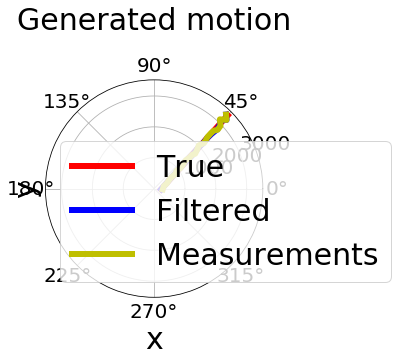

In [3]:
if __name__ == "__main__":
    
    Xp = Ass9_1().Xp
    Zp_fixed = Ass9_1().Zp
    Ans = Ass9_2(Zp_fixed).Kalman
    
    plt.polar(Xp[1,1:],Xp[0,1:], linewidth = 6, label = "True", color = "r")
    plt.polar(Ans[3,1:],Ans[2,1:], linewidth = 6, label = "Filtered", color = "b")
    plt.polar(Zp_fixed[1,1:],Zp_fixed[0,1:], linewidth = 6, label = "Measurements", color = "y")

    plt.legend(fontsize = 30)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.tick_params(labelsize = 20)
    plt.xlabel("x", fontsize = 30)
    plt.ylabel("y", fontsize = 30)
    plt.title("Generated motion\n", fontsize = 30)
    plt.show()

In [4]:
Ans[2,:] - Xp[0,:])

SyntaxError: invalid syntax (<ipython-input-4-cccf54fb6ce1>, line 2)

In [5]:
n = Ass9_1().N
l1 = np.ones(n)*Ass9_1().sigma_etD2
D = Zp_fixed[0,:]
l2 = (D**2)*Ass9_1().sigma_etb2
cond_num = np.zeros((n))

for i in range(n):
    if l1[i]>l2[i]:
        cond_num[i] = l1[i]/l2[i]
    else:
        cond_num[i] = l2[i]/l1[i]

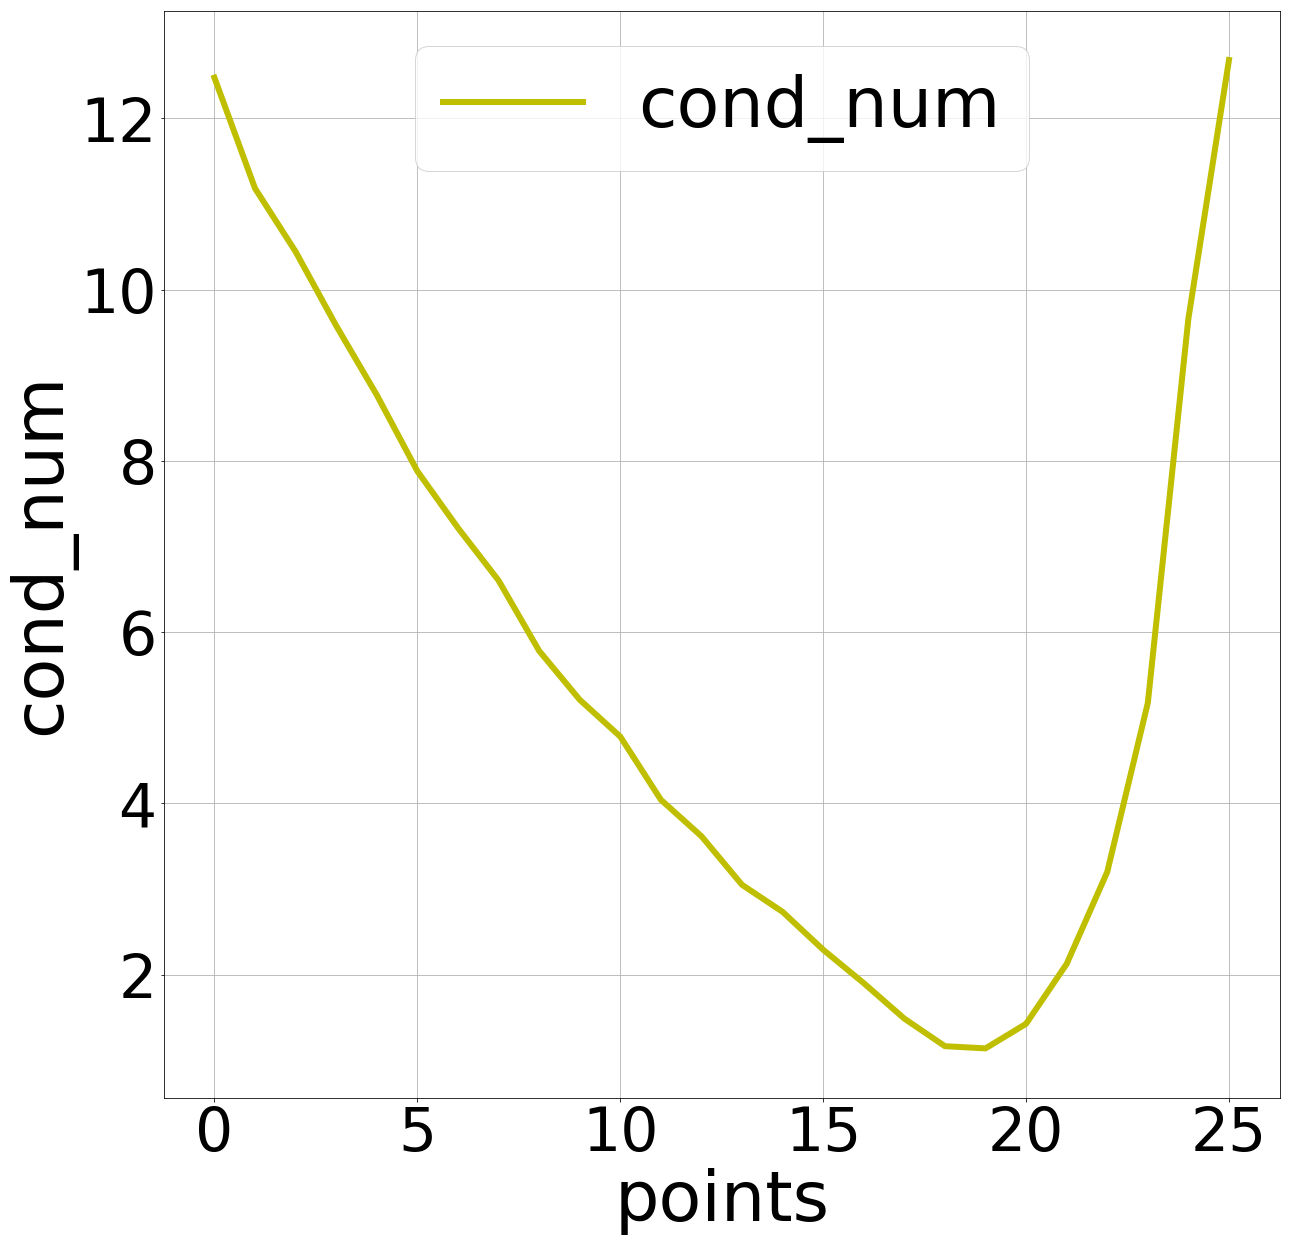

In [6]:
# Compare of true errors and errors of estimation of coordinates
plt.plot(cond_num, linewidth = 6, label = "cond_num", color = "y")
plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,30)
plt.tick_params(labelsize = 60)
plt.grid()
plt.xlabel("points", fontsize = 70)
plt.ylabel("cond_num", fontsize = 70)
# plt.title("Compare of true errors and errors of estimation of coordinates\n", fontsize = 70)
plt.show()

In [98]:
if __name__ == "__main__":

    n = Ass9_1().N
    Error_filt = np.zeros((2,n,500))
    Error_extr = np.zeros((2,n,500))
    
    for k in range(500):
        Xp = Ass9_1().Xp
        Zp_fixed = Ass9_1().Zp
        Ans = Ass9_2(Zp_fixed).Kalman
            
        est_filt = Ans[2:,:]
        est_extr = Ans[:2,:]
        Error_filt[:,:,k] = (Xp - est_filt)**2
        Error_extr[:,:,k] = (Xp - est_extr)**2
        
        Xc = Ass9_1().Xc
    
    Final_err_filt = np.sqrt(np.sum(Error_filt, axis = 2)/(500.0-1.0))
    Final_err_extr = np.sqrt(np.sum(Error_extr, axis = 2)/(500.0-1.0))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in divide


In [109]:
Final_err_filt[0,:]/np.sqrt(Ass9_1().sigma_etD2)

array([  2.65608454e+03,   1.02685178e+00,   1.01373816e+00,
         9.29444999e-01,   8.32100988e-01,   7.79157371e-01,
         7.29855518e-01,   6.78013059e-01,   6.40173939e-01,
         6.11987252e-01,   5.78417707e-01,   5.63823448e-01,
         5.40794272e-01,   5.29483564e-01,   5.11351283e-01,
         5.08465252e-01,   5.02476352e-01,   4.87409689e-01,
         4.74234219e-01,   4.49418882e-01,   4.27376360e-01,
         4.17116360e-01,   3.99725120e-01,   4.04850358e-01,
         3.97932306e-01,   3.76461011e-01])

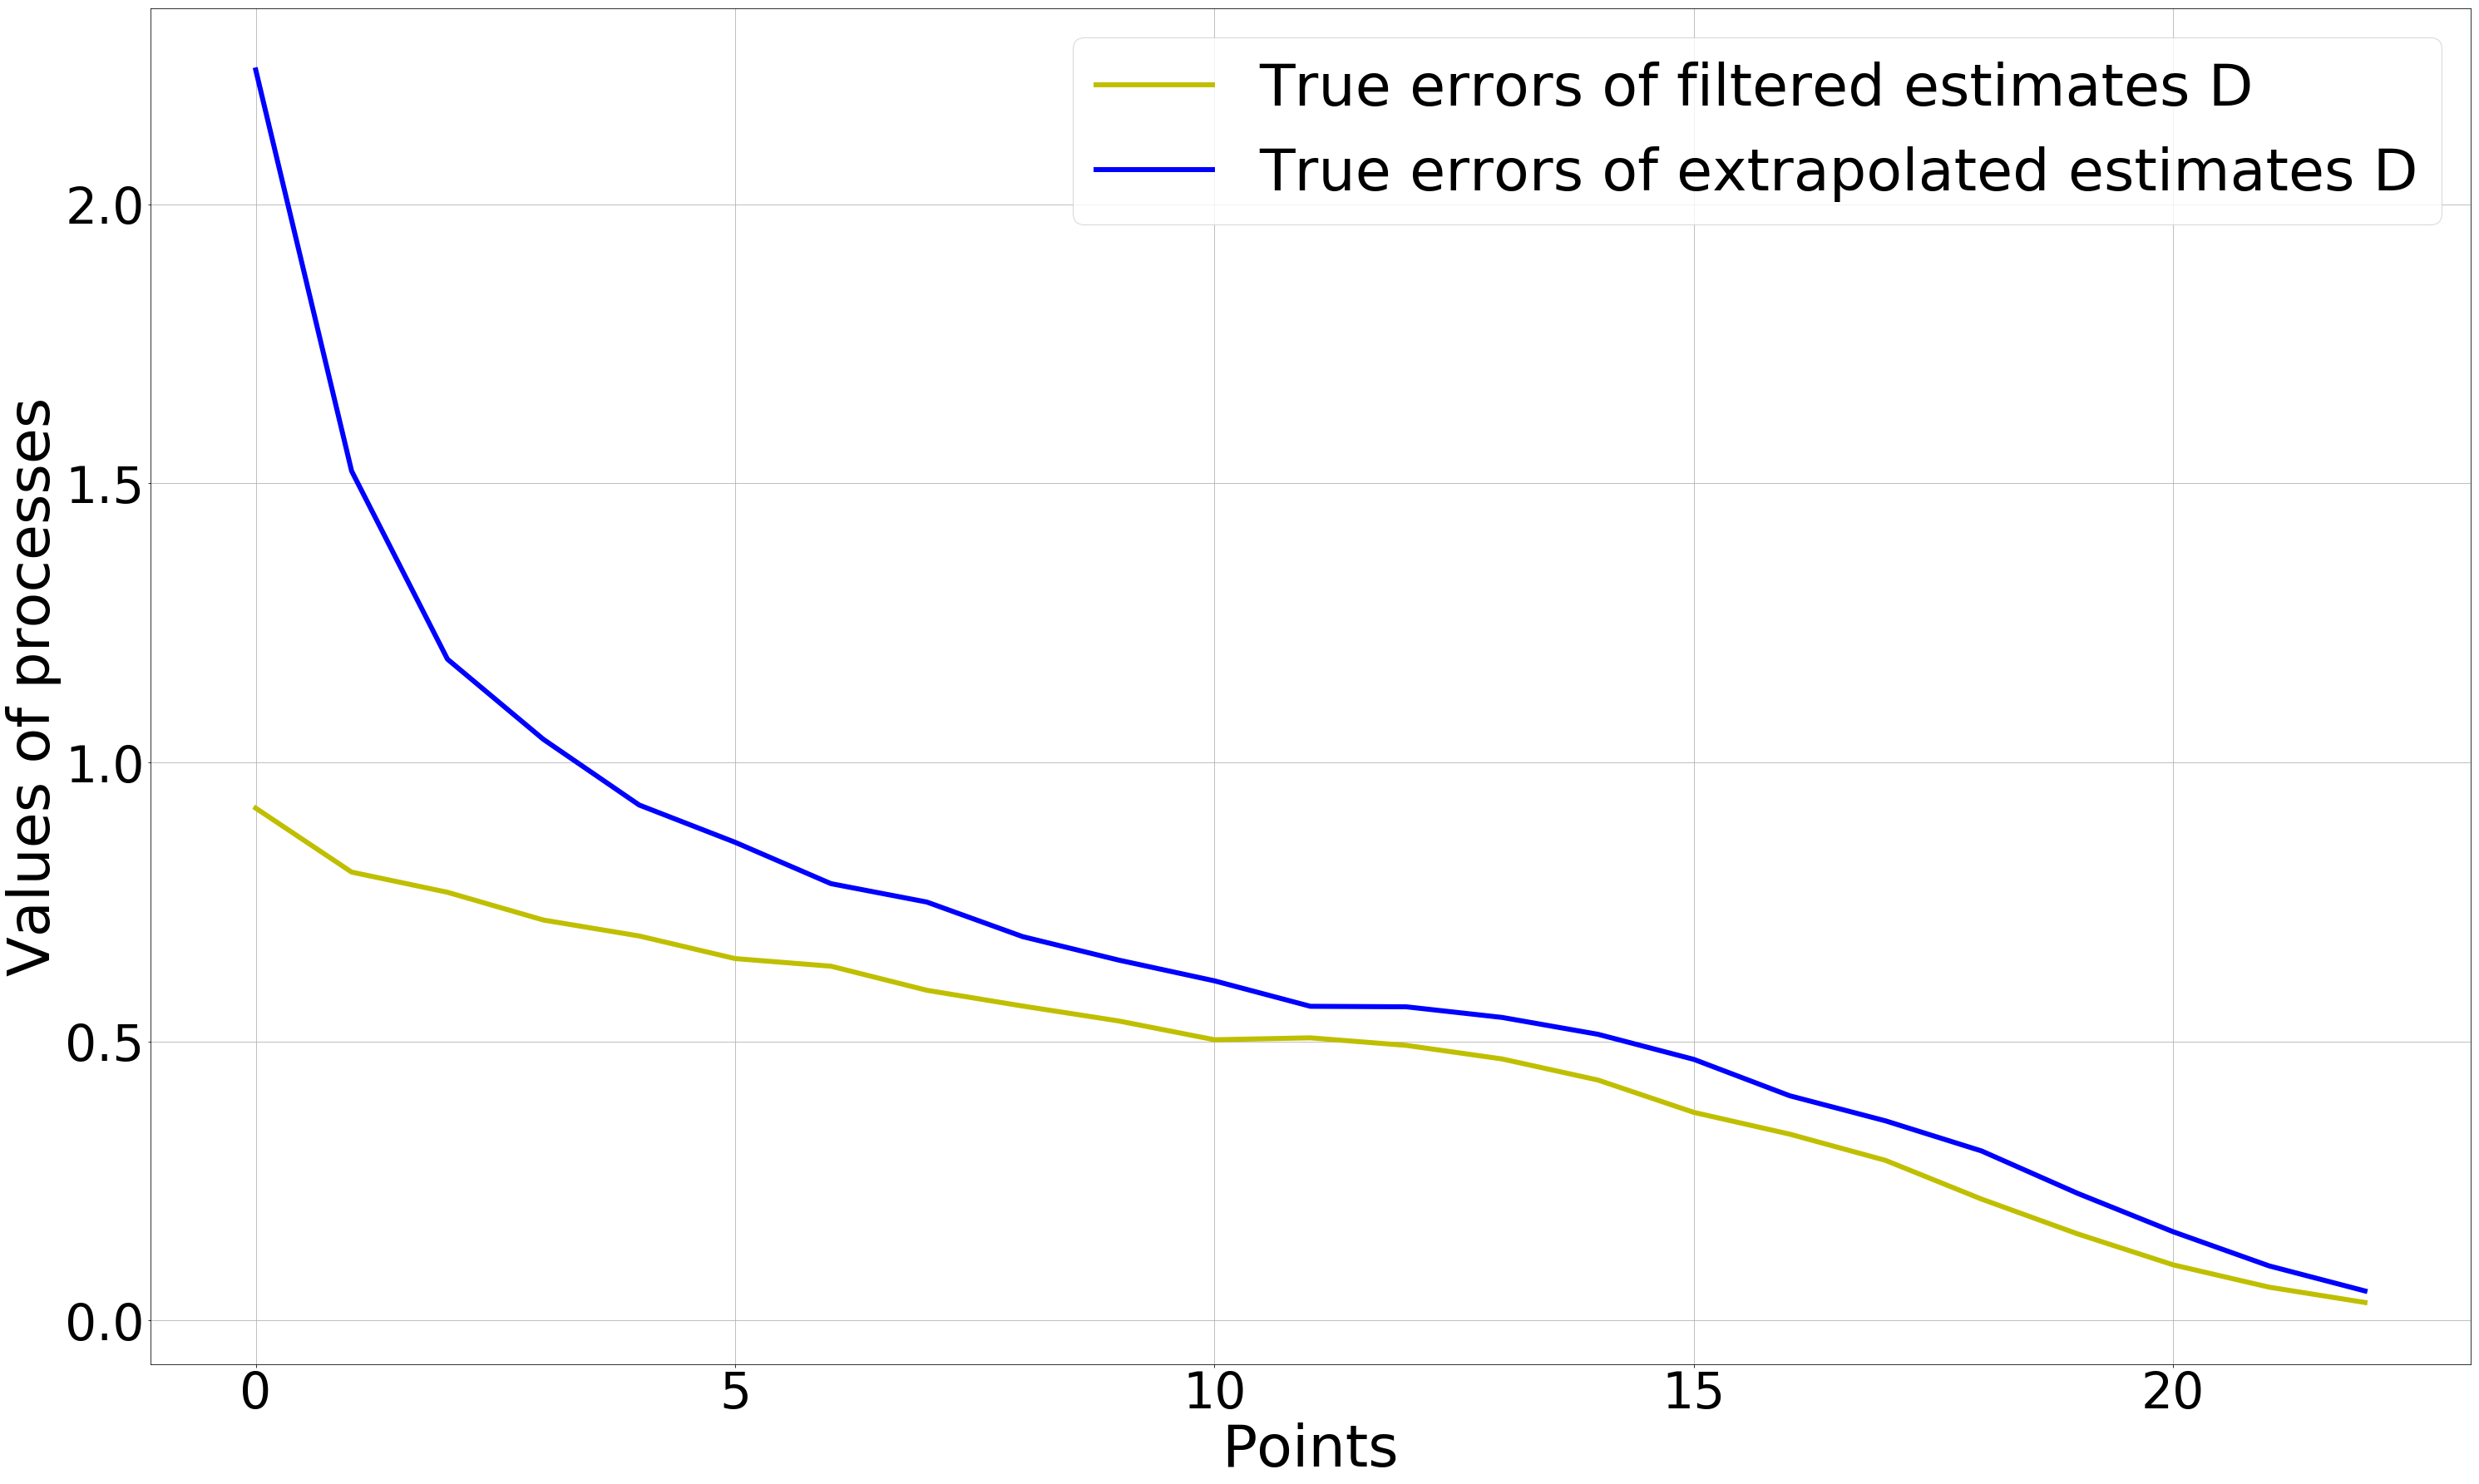

In [85]:
# Compare of true errors and errors of estimation of coordinates
plt.plot(Final_err_filt[0,3:]/np.sqrt(Ass9_1().sigma_etD2), linewidth = 6, label = "True errors of filtered estimates D", color = "y")
plt.plot(Final_err_extr[0,3:]/np.sqrt(Ass9_1().sigma_etD2), linewidth = 6, label = "True errors of extrapolated estimates D", color = "b")

plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,30)
plt.tick_params(labelsize = 60)
plt.grid()
plt.xlabel("Points", fontsize = 70)
plt.ylabel("Values of processes", fontsize = 70)
# plt.title("Compare of true errors and errors of estimation of coordinates\n", fontsize = 70)
plt.show()

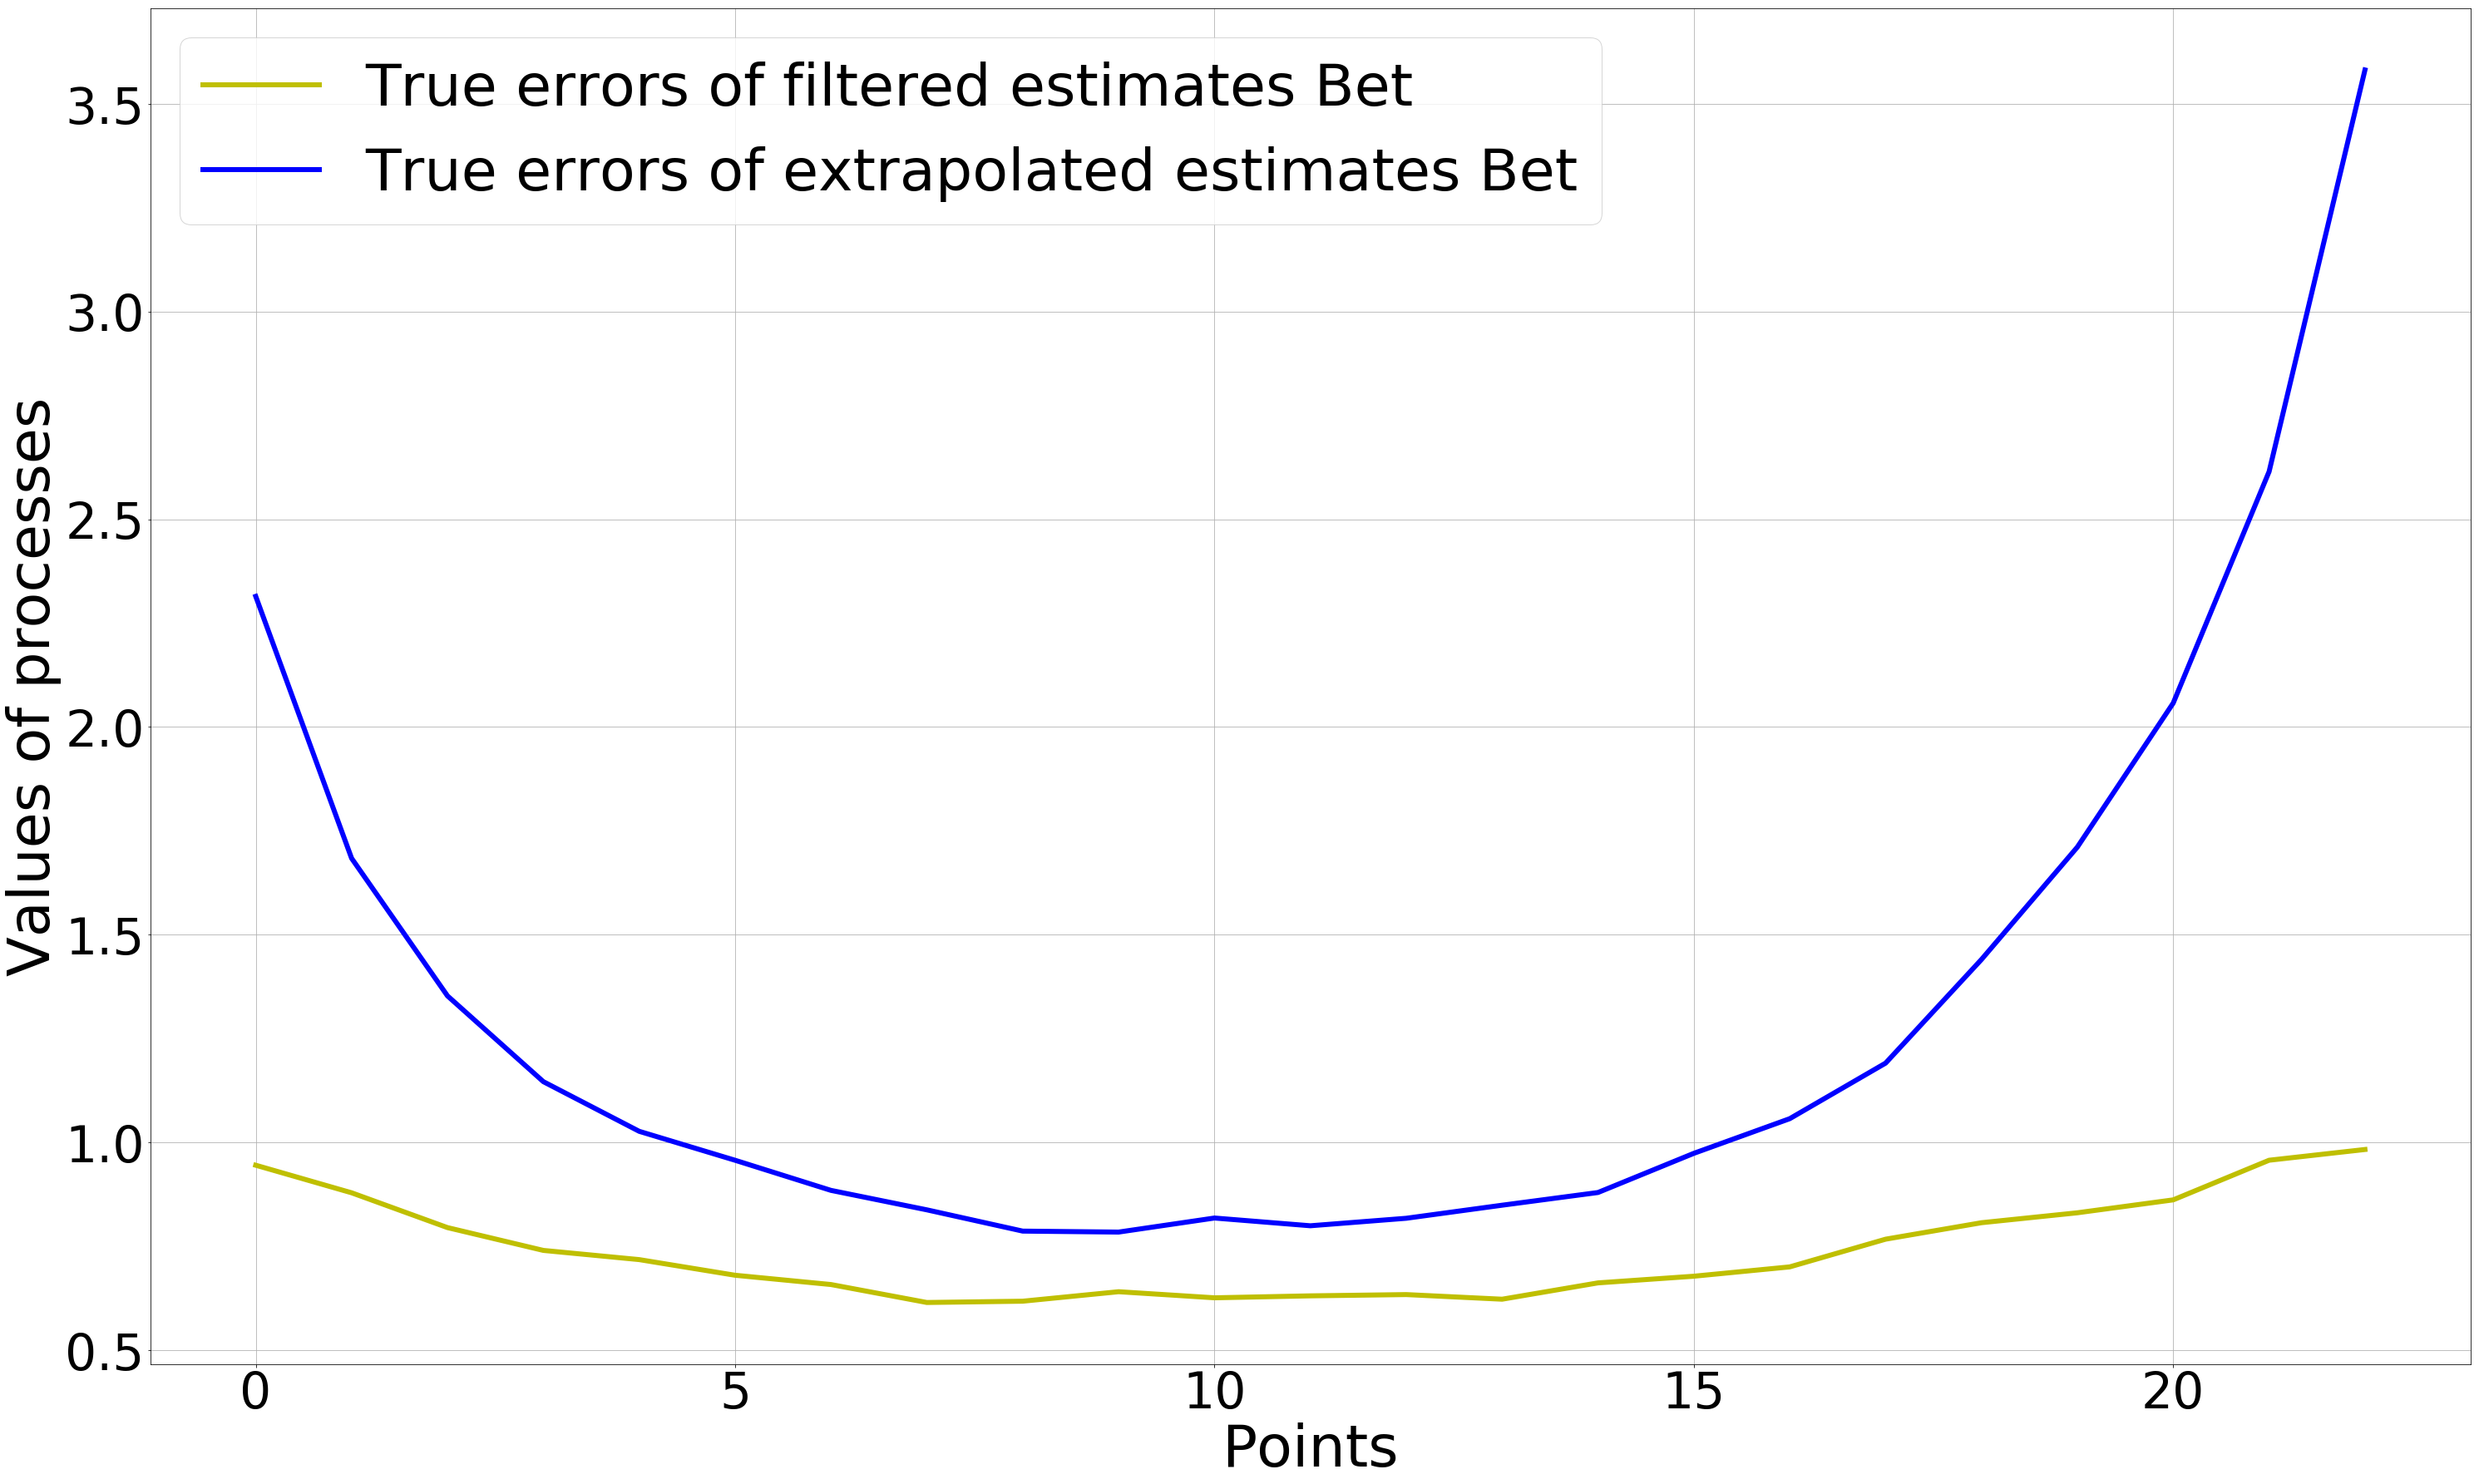

In [86]:
# Compare of true errors and errors of estimation of coordinates
plt.plot(Final_err_filt[1,3:]/np.sqrt(Ass9_1().sigma_etb2), linewidth = 6, label = "True errors of filtered estimates Bet", color = "y")
plt.plot(Final_err_extr[1,3:]/np.sqrt(Ass9_1().sigma_etb2), linewidth = 6, label = "True errors of extrapolated estimates Bet", color = "b")

plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,30)
plt.tick_params(labelsize = 60)
plt.grid()
plt.xlabel("Points", fontsize = 70)
plt.ylabel("Values of processes", fontsize = 70)
# plt.title("Compare of true errors and errors of estimation of coordinates\n", fontsize = 70)
plt.show()

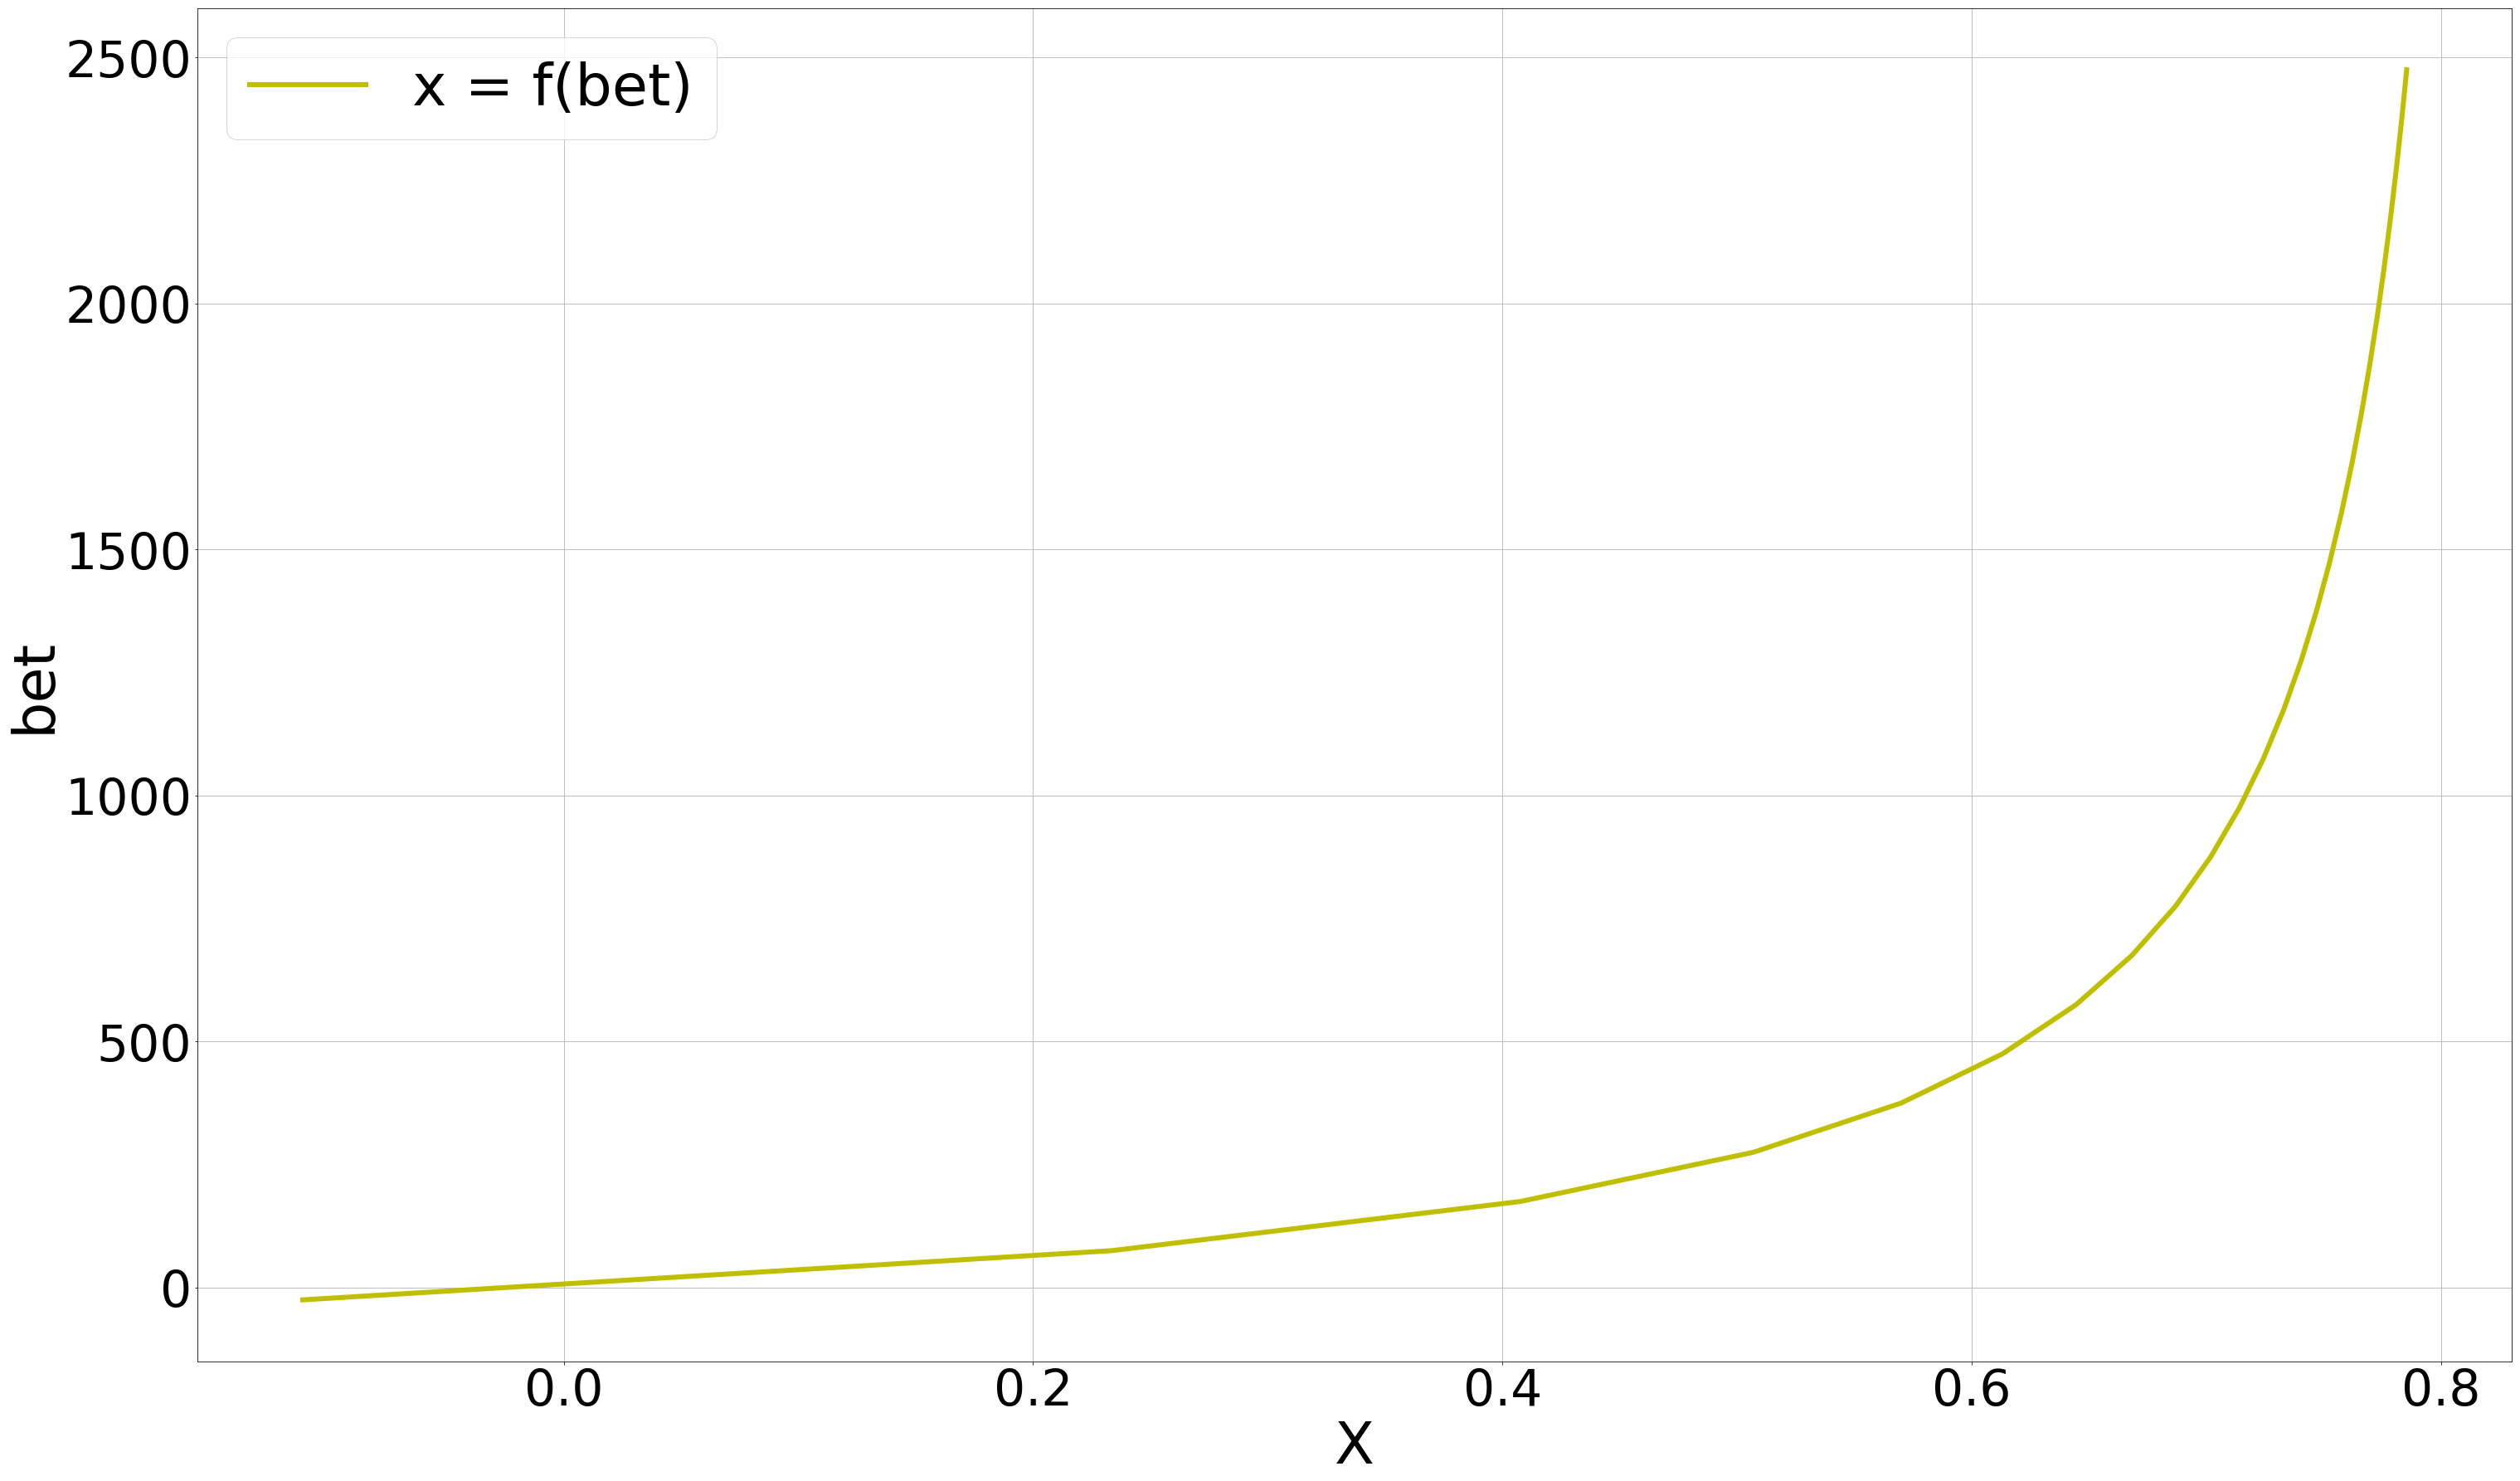

In [87]:
# Compare of true errors and errors of estimation of coordinates
plt.plot(Xp[1,:], Xc[0,:], linewidth = 6, label = "x = f(bet)", color = "y")
plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,30)
plt.tick_params(labelsize = 60)
plt.grid()
plt.xlabel("X", fontsize = 70)
plt.ylabel("bet", fontsize = 70)
# plt.title("Compare of true errors and errors of estimation of coordinates\n", fontsize = 70)
plt.show()